In [39]:
import pandas as pd
import skimage.io as skio
import matplotlib.pyplot as plt
from tqdm import tqdm # for progress bar
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import models, layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Input, Concatenate, Activation
from tensorflow_probability import distributions as tf_prob
from tensorflow.keras.models import Sequential
import glob
import random
import keras
import tensorflow as tf
import numpy as np

In [3]:
covidimg = glob.glob('/Users/a080528/Downloads/COVID-19_Radiography_Dataset/COVID/images/*.png')
normalimg = glob.glob('/Users/a080528/Downloads/COVID-19_Radiography_Dataset/Normal/images/*.png')

random_covid = random.sample(covidimg, 1600)
random_normal = random.sample(normalimg, 6400)


In [4]:
xtrain_cov = np.empty([1280,299,299])
xtrain_nor = np.empty([5120,299,299])
ytrain_cov = np.ones(1280)
ytrain_nor = np.zeros(5120)

xtest_cov = np.empty([320,299,299])
xtest_nor = np.empty([1280,299,299])
ytest_cov = np.ones(320)
ytest_nor = np.zeros(1280)

for i in range(1280):
    xtrain_cov[i, :, :] = skio.imread(random_covid[i])
for i in range(1280, len(random_covid)-1):
    xtest_cov[i-1280, :, :] = skio.imread(random_covid[i])

for i in range(5120):
    xtrain_nor[i, :, :] = skio.imread(random_normal[i])
for i in range(5120, len(random_normal)-1):
    xtest_nor[i-5120, :, :] = skio.imread(random_normal[i])

In [5]:
x_train = np.concatenate([xtrain_cov,xtrain_nor])
x_test = np.concatenate([xtest_cov,xtest_nor])
y_train = np.concatenate([ytrain_cov,ytrain_nor])
y_test = np.concatenate([ytest_cov,ytest_nor])

In [6]:
# Verifying dataset
print('Image shape: training', x_train.shape, 'testing: ',x_test.shape)
print('Target shape: training', y_train.shape, 'testing: ',y_test.shape)
print('Target: ',y_train)

Image shape: training (6400, 299, 299) testing:  (1600, 299, 299)
Target shape: training (6400,) testing:  (1600,)
Target:  [1. 1. 1. ... 0. 0. 0.]


In [7]:
# Convert the images into 3 channels as MNIST images are Black and White so have 1 channel

x_train=np.dstack([x_train] * 3)
x_test=np.dstack([x_test]*3)

# Reshape images as per the tensor format required by tensorflow

x_train = x_train.reshape(-1, 299,299,3)
x_test= x_test.reshape (-1,299,299,3)

In [8]:
# Resize the images 48*48 as required by VGG16

from keras.preprocessing.image import img_to_array, array_to_img
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])
x_train.shape, x_test.shape

((6400, 48, 48, 3), (1600, 48, 48, 3))

In [9]:
## listing the folders containing images

# preparing array that can be used later

class_names=['Normal', 'Covid']
val_class_names =['Normal', 'Covid']
test_class_names=['Normal', 'Covid']

# Function to know the name of the element

def Get_Element_Name(argument):
    switcher = {
        0: "Normal",
        1: "Covid"
    }
    return switcher.get(argument, "Invalid")

In [91]:
# Preparing data

x=[] # to store array value of the images
x=x_train
y=[] # to store the labels of the images
y=y_train

test_images=[]
test_images=x_test
test_images_Original=[]
test_images_Original=x_test
test_image_label=[] # to store the labels of the images
test_image_label=y_test

val_images=[]
val_images= x_test
val_images_Original=[]
val_images_Original= x_test
val_image_label=[] # to store the labels of the images
val_image_label= y_test # to store the labels of the images

print("Preparing Dataset Completed.")

Preparing Dataset Completed.


## Verification of data

In [92]:
# Training Dataset
print("Training Dataset")

x=np.array(x) # Converting to np arrary to pass to the model
print(x.shape)

y=to_categorical(y) # onehot encoding of the labels
# print(y)
print(y.shape)

# Test Dataset
print("Test Dataset")

test_images=np.array(test_images) 
print(test_images.shape)

test_image_label=to_categorical(test_image_label) # onehot encoding of the labels)
print(test_image_label.shape)

# Validation Dataset
print("Validation Dataset")

val_images=np.array(val_images) 
print(val_images.shape)

val_image_label=to_categorical(val_image_label) # onehot encoding of the labels)
print(val_image_label.shape)

Training Dataset
(6400, 48, 48, 3)
(6400, 2)
Test Dataset
(1600, 48, 48, 3)
(1600, 2)
Validation Dataset
(1600, 48, 48, 3)
(1600, 2)


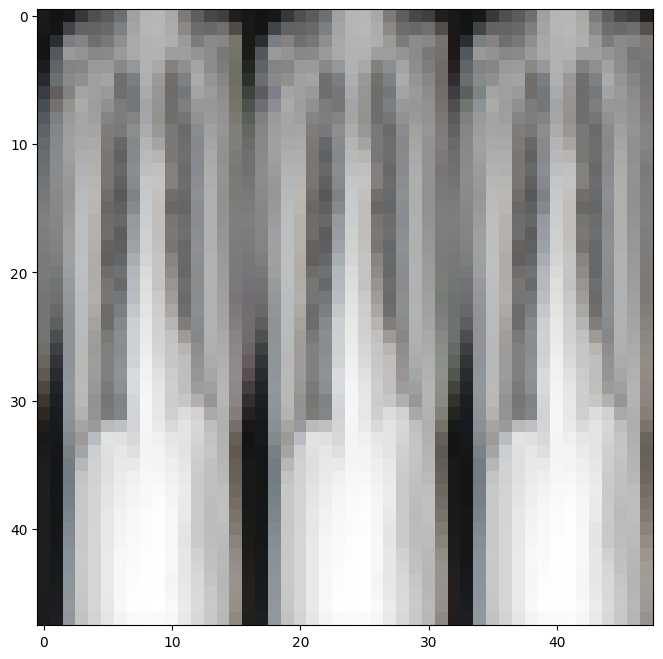

In [12]:
plt.figure(figsize=(10,8))
plt.imshow(x[0].astype('int32'))
plt.show()

## Modeling from transfer learning of VGG16

In [13]:
# Check properties of the model that we are going to use for Transfer Learning

print("Summary of default VGG16 model.\n")

# we are using VGG16 for transfer learnin here. So we have imported it
from tensorflow.keras.applications import VGG16

# initializing model with weights='imagenet'i.e. we are carring its original weights
model_vgg16=VGG16(weights='imagenet')

# display the summary to see the properties of the model
model_vgg16.summary()

Summary of default VGG16 model.



Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

## Customized VGG

In [14]:
# Modelling WITH Transfer Learning

# Here we will prepare model as per our requirements

print("Summary of Custom VGG16 model.\n")
print("1) We setup input layer and 2) We removed top (last) layer. \n")

# let us prepare our input_layer to pass our image size. default is (224,224,3). we will change it to (224,224,3)
input_layer=layers.Input(shape=(48,48,3))

# initialize the transfer model VGG16 with appropriate properties per our need.
# we are passing paramers as following
# 1) weights='imagenet' - Using this we are carring weights as of original weights.
# 2) input_tensor to pass the VGG16 using input_tensor
# 3) we want to change the last layer so we are not including top layer
model_vgg16=VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)

# See the summary of the model with our properties.
model_vgg16.summary()

Summary of Custom VGG16 model.

1) We setup input layer and 2) We removed top (last) layer. 



Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# access the current last layer of the model and add flatten and dense after it

def nnelu(x):
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(x))

    
print("Summary of Custom VGG16 model.\n")
print("1) We flatten the last layer of original VGG and added 1 Dense layer and 1 output layer.\n")


last_layer=model_vgg16.output # we are taking last layer of the model
no_components = 2
no_classes = 2

# Add flatten layer: we are extending Neural Network by adding flattn layer
flatten=layers.Flatten()(last_layer) 

# Add dense layer to the final output layer
output_weight = layers.Dense(no_components, activation='softmax', name = 'weight')(flatten)
output_mu = layers.Dense(no_components, name = 'mu')(flatten)
output_sigma = layers.Dense(no_components, activation= nnelu, name = 'sigma')(flatten)
output_layer = Concatenate()([output_weight, output_mu, output_sigma])

# Creating modle with input and output layer
model=models.Model(inputs=input_layer,outputs=output_layer)

# Summarize the model
model.summary()

Summary of Custom VGG16 model.

1) We flatten the last layer of original VGG and added 1 Dense layer and 1 output layer.



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 48, 48,    │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 48, 48,    │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 24, 24,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 24, 24,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 24, 24,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 12, 12,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 12, 12,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 12, 12,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 12, 12,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 6, 6, 256) │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 6, 6, 512) │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 6, 6, 512) │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 6, 6, 512) │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 3, 3, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 3, 3, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 3, 3, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 14,717,766 (56.14 MB)

 Trainable params: 3,078 (12.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
# we will freez all the layers except the last layer
# we are making all the layers intrainable except the last layer
print("We are making all the layers intrainable except the last layer. \n")
for layer in model.layers[:-4]:
    layer.trainable=False
model.summary()

We are making all the layers intrainable except the last layer. 



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 48, 48,    │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 48, 48,    │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 24, 24,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 24, 24,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 24, 24,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 12, 12,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 12, 12,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 12, 12,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 12, 12,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 6, 6, 256) │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 6, 6, 512) │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 6, 6, 512) │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 6, 6, 512) │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 3, 3, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 3, 3, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 3, 3, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 14,717,766 (56.14 MB)

 Trainable params: 3,078 (12.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
def gaussianloss(y_true, par_vec):

    y_true = tf.argmax(y_true, axis = 1)
    
    w = par_vec[:, :no_components]
    m = par_vec[:, no_components:2*no_components]
    lgs = par_vec[:, 2*no_components:]
    
    weights_pred = tf.nn.softmax(w, axis=-1)

    likelihood = -0.5 * (tf.math.log(2 * np.pi) + 2*lgs + tf.square(tf.expand_dims(tf.cast(y_true, tf.float32), axis = -1) - m) / (tf.square(tf.exp(lgs))+1e-6)) + tf.math.log(weights_pred)
    # log-sum trick
    max_llikelihood = tf.reduce_max(likelihood, axis=-1, keepdims=True)

    llikelihood = max_llikelihood + tf.math.log(tf.reduce_sum(tf.exp(likelihood - max_llikelihood), axis=-1, keepdims = True))
    #weighted_llikelihood = tf.reduce_sum(llikelihood * weights_pred, axis=-1)

    # Weighted sum of log-likelihoods
    loss = -tf.reduce_mean(llikelihood)


    return loss

## Training Setting

In [95]:
# Train the Model

from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=5)
print("Splitting data for train and test completed.")
model.compile(loss= gaussianloss, optimizer='adam',metrics=['accuracy'])
print("Model compilation completed.")

Splitting data for train and test completed.
Model compilation completed.


In [19]:
history = model.fit(xtrain,ytrain,epochs=10,batch_size=128,verbose=True,validation_data=(xtest,ytest))
print("Fitting the model completed.")

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 728ms/step - accuracy: 0.6504 - loss: nan - val_accuracy: 0.8125 - val_loss: nan
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 726ms/step - accuracy: 0.7973 - loss: nan - val_accuracy: 0.8125 - val_loss: nan
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 737ms/step - accuracy: 0.8039 - loss: nan - val_accuracy: 0.8125 - val_loss: nan
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 729ms/step - accuracy: 0.8022 - loss: nan - val_accuracy: 0.8125 - val_loss: nan
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 721ms/step - accuracy: 0.7964 - loss: nan - val_accuracy: 0.8125 - val_loss: nan
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 748ms/step - accuracy: 0.7975 - loss: nan - val_accuracy: 0.8125 - val_loss: nan
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 719ms/step - accuracy: 0.7962 - loss: nan - val_accuracy: 0.8125 - val_loss: nan
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 719ms/step - accuracy: 0.7968 - loss: nan - val_accuracy: 0.8125 - val_loss: nan
Epoch 9/10
40/40

In [21]:
# This function helps to predict individual image supplied to it

# Function 1

def predict(img_name):
    img=image.load_img(img_name,target_size=(48,48))
    img=image.img_to_array(img)
    plt.imshow(img.astype('int32'))
    plt.show()
    img=preprocess_input(img)

    prediction=model.predict(img.reshape(1,48,48,3))
    output=np.argmax(prediction)

    print(class_names[output] + ": " + Get_Element_Name(class_names[output]))

    
# Function 2

# This function plots the image supplied in array
def plot_image(i, predictions_array, true_label, img): # taking index and 3 arrays viz. prediction array, true label array and image array
    
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img.astype('int32'))
    
    predicted_label=np.argmax(predictions_array)
    true_label=np.argmax(true_label)

    if predicted_label == true_label: #setting up label color
        color='green' # correct then blue colour
    else:
        color='red' # wrong then red colour
    
    plt.xlabel("{} {:2.0f}% \n ({})".format(Get_Element_Name(predicted_label), 
                                            100*np.max(predictions_array), Get_Element_Name(true_label), 
                                            color=color, horizontalalignment='left'))

# Function 3

# This function plots bar chart supplied in the array data
def plot_value_array(i, predictions_array, true_label): # taking index along with predictions and true label array
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    predicted_label=np.argmax(predictions_array)
    true_label=np.argmax(true_label)

    if predicted_label == 0:
        predicted_label=1
    if true_label == 0:
        true_label=1
    
    thisplot=plt.bar(range(10), predicted_label, color='seashell')
    plt.ylim([0,1])

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

In [28]:
model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[nan, nan, nan, nan, nan, nan]], dtype=float32)

In [ ]:
# Preparing prediction arrary
predictions=[]

for img in tqdm(val_images):
    img=img.reshape(1,48,48,3)
    predictions.append(model.predict(img))

In [ ]:
# Prediction of individual images taken from internet

# call the function

# defining parameters to pass to function
i=random.randrange(1, 10000) # image number 12. You may change value of i for play around
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
# we are passing "val_images_Original" just to show original image instead of "val_images" 
# which is preprocessed as VGG16 process and used for prediction.
plot_image(i,predictions, val_image_label, val_images_Original) 
plt.subplot(1,2,2)
plot_value_array(i, predictions, val_image_label)
plt.show()

# Try simple VGG network

In [148]:
s_y = np.empty((len(y), 1))
for i in range(len(y)):
    if y[i,0] == 0:
        s_y[i, 0] = 1
    else:
        s_y[i, 0] = 0

def data_augmentation(imgs):
    # input dimension should be (number of image, shapex, shapey, channel = 3)
    datastack = np.empty(imgs.shape)
    numi = imgs.shape[0]
    for i in range(numi):
        datastack[i,:,:,:] = imgs[i,:,:,:]/255
        
    return datastack

In [152]:
# Train the Model

from sklearn.model_selection import train_test_split

s_xtrain, s_xtest, s_ytrain, s_ytest = train_test_split(x,s_y,test_size=0.2,random_state=5)
s_xtrain, s_xtest = data_augmentation(s_xtrain), data_augmentation(s_xtest)
print("Splitting data for train and test completed.")
model.compile(loss= gaussianloss, optimizer='adam',metrics=['accuracy'])
print("Model compilation completed.")

Splitting data for train and test completed.
Model compilation completed.


In [191]:
input = Input(shape =(48,48,3))

L = tf.keras.layers.Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu', name = 'conv1')(input)
L = tf.keras.layers.Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu', name = 'conv2')(L)
L = tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same', name = 'maxp1')(L)
L = tf.keras.layers.Flatten()(L)
L = tf.keras.layers.Dropout(0.2)(L)
#x = tf.keras.layers.Dense(units = 512, activation ='relu')(x) 

no_components = 2
output_weight = layers.Dense(no_components, activation='softmax', name = 'weight')(L)
output_mu = layers.Dense(no_components, name = 'mu')(L)
output_sigma = layers.Dense(no_components, activation= nnelu, name = 'sigma')(L)
output_layer = Concatenate()([output_weight, output_mu, output_sigma])


test_model = Model(inputs=input, outputs =output_layer)
test_model.summary()

Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 48, 48,    │      1,792 │ input_layer_23[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 48, 48,    │     36,928 │ conv1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxp1               │ (None, 24, 24,    │          0 │ conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_20          │ (None, 36864)     │          0 │ maxp1[0][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 36864)     │          0 │ flatten_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weight (Dense)      │ (None, 2)         │     73,730 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 2)         │     73,730 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigma (Dense)       │ (None, 2)         │     73,730 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 6)         │          0 │ weight[0][0],     │
│ (Concatenate)       │                   │            │ mu[0][0],         │
│                     │                   │            │ sigma[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 259,910 (1015.27 KB)

 Trainable params: 259,910 (1015.27 KB)

 Non-trainable params: 0 (0.00 B)

In [218]:
def gaussianloss(y_true, par_vec):

    #y_true = tf.argmax(y_true, axis = 1)
    
    w = par_vec[:, :no_components]
    m = par_vec[:, no_components:2*no_components]
    lgs = par_vec[:, 2*no_components:]
    
    weights_pred = tf.nn.softmax(w, axis=-1)
    predict_label = tf.argmax(weights_pred, axis = 1)
    predict_label = tf.reshape(predict_label,[-1,1])
    tf.print(y_true.shape)
    tf.print(predict_label.shape)
    #tf.print(w)
    likelihood = -0.5 * (tf.math.log(2 * np.pi) + 2*lgs + tf.square(tf.expand_dims(tf.cast(y_true, tf.float32), axis = -1) - m) / (tf.square(tf.exp(lgs))+1e-6)) + tf.math.log(weights_pred)
    # log-sum trick
    max_llikelihood = tf.reduce_max(likelihood, axis=-1, keepdims=True)

    llikelihood = max_llikelihood + tf.math.log(tf.reduce_sum(tf.exp(likelihood - max_llikelihood), axis=-1, keepdims = True))
    #weighted_llikelihood = tf.reduce_sum(llikelihood * weights_pred, axis=-1)

    # Weighted sum of log-likelihoods
    loss = -tf.reduce_mean(llikelihood)


    return loss

In [219]:
test_model.compile(loss= gaussianloss, optimizer=Adam(learning_rate=1e-6),metrics=['accuracy'])
history = test_model.fit(s_xtrain,ytrain,epochs=1,batch_size=128,verbose=True,validation_data=(s_xtest,ytest))

TensorShape([128, 1])
TensorShape([128, 1])
 1/40 ━━━━━━━━━━━━━━━━━━━━ 31s 813ms/step - accuracy: 0.7734 - loss: 1.4648TensorShape([128, 1])
TensorShape([128, 1])
 2/40 ━━━━━━━━━━━━━━━━━━━━ 13s 354ms/step - accuracy: 0.7520 - loss: 1.4690TensorShape([128, 1])
TensorShape([128, 1])
 3/40 ━━━━━━━━━━━━━━━━━━━━ 13s 354ms/step - accuracy: 0.7365 - loss: 1.4708TensorShape([128, 1])
TensorShape([128, 1])
 4/40 ━━━━━━━━━━━━━━━━━━━━ 12s 357ms/step - accuracy: 0.7282 - loss: 1.4718TensorShape([128, 1])
TensorShape([128, 1])
 5/40 ━━━━━━━━━━━━━━━━━━━━ 12s 358ms/step - accuracy: 0.7241 - loss: 1.4720TensorShape([128, 1])
TensorShape([128, 1])
 6/40 ━━━━━━━━━━━━━━━━━━━━ 12s 353ms/step - accuracy: 0.7213 - loss: 1.4721TensorShape([128, 1])
TensorShape([128, 1])
 7/40 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.7211 - loss: 1.4722TensorShape([128, 1])
TensorShape([128, 1])
 8/40 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.7208 - loss: 1.4720TensorShape([128, 1])
TensorShape([128, 1])
 9/4